# Fastvlm + RLHF(SFT+DPO)

In [19]:
import os, sys, json, torch, random, glob, math, types, re, unicodedata, csv, time
import matplotlib.pyplot as plt
import torchvision.transforms as T
from pathlib import Path
from importlib.machinery import ModuleSpec
from PIL import Image
from tqdm import tqdm
from collections import Counter, defaultdict
from torch.utils.data import Dataset
from transformers import TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model
from llava.model.builder import load_pretrained_model
from peft import PeftModel, LoraConfig, get_peft_model
from collections import Counter
from tqdm import tqdm

Fastvlm_1.5b_stage3 Model Local Offline Loading

In [5]:
# Mount Google Drive
from google.colab import drive

if not os.path.exists('/content/drive'):
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("Google Drive is already mounted")

# Path configuration
PROJECT = "/content/drive/MyDrive/FastVLM_RLHF"
ML_FASTVLM = os.path.join(PROJECT, "ml-fastvlm")
CKPT_DIR = os.path.join(ML_FASTVLM, "checkpoints", "llava-fastvithd_1.5b_stage3")

assert os.path.exists(CKPT_DIR), f"Model path not found: {CKPT_DIR}"
print("Model directory exists:", CKPT_DIR)

# Enforce offline mode — disable Hugging Face access
os.environ["HF_HUB_OFFLINE"] = "1"
os.environ["TRANSFORMERS_OFFLINE"] = "1"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Check vision_tower configuration
CFG = os.path.join(CKPT_DIR, "config.json")
with open(CFG) as f:
    cfg = json.load(f)

print("BEFORE vision_tower:", cfg.get("vision_tower"))
if cfg.get("vision_tower") is None:
    pass
print("AFTER vision_tower:", cfg.get("vision_tower"))

# Load the local ml-fastvlm package
if ML_FASTVLM not in sys.path:
    sys.path.append(ML_FASTVLM)

# Install dependencies only on first run to avoid redundant installs
if not os.path.exists(os.path.join(ML_FASTVLM, "llava.egg-info")):
    print("First run: installing local ml-fastvlm package...")
    !cd {ML_FASTVLM} && pip install -e . -q
else:
    print("Local package already exists, no need to reinstall.")

# Load the model (fp16 to avoid triggering bitsandbytes)
from llava.model.builder import load_pretrained_model
import torch

ret = load_pretrained_model(
    model_path=CKPT_DIR,
    model_base=None,
    model_name="FastVLM-1.5B",
    device_map="auto",
    torch_dtype=torch.float16,
)

# Adaptive unpacking logic
def pick_roles(items):
    mdl = tok = proc = None
    extra = []
    for x in items:
        if hasattr(x, "generate") and mdl is None:
            mdl = x
        elif hasattr(x, "encode") and tok is None:
            tok = x
        elif proc is None:
            proc = x
        else:
            extra.append(x)
    return mdl, tok, proc, extra

if not isinstance(ret, tuple):
    raise RuntimeError(f"Unexpected return from load_pretrained_model: {type(ret)}")

model, tokenizer, image_processor, extra = pick_roles(ret)

print(f"Unpacking complete: model={type(model).__name__}, tokenizer={type(tokenizer).__name__}, "
      f"image_processor={type(image_processor).__name__ if image_processor else None}, extra={len(extra)}")
print("Model successfully loaded, device:", model.device)

# Quantization safeguard — ensure the model is not in 4/8-bit mode
if getattr(model, "is_loaded_in_4bit", False) or getattr(model, "is_loaded_in_8bit", False):
    raise RuntimeError("Detected a 4-bit or 8-bit quantized model. Please use an fp16 base model before applying LoRA-SFT.")
print("dtype =", getattr(model, "dtype", "unknown"))

print("FastVLM is now ready for subsequent RLHF or evaluation tasks (no inference test required).")

Google Drive is already mounted
Model directory exists: /content/drive/MyDrive/FastVLM_RLHF/ml-fastvlm/checkpoints/llava-fastvithd_1.5b_stage3
BEFORE vision_tower: None
AFTER vision_tower: None
Local package already exists, no need to reinstall.
Unpacking complete: model=LlavaQwen2ForCausalLM, tokenizer=Qwen2Tokenizer, image_processor=int, extra=0
Model successfully loaded, device: cuda:0
dtype = torch.float16
FastVLM is now ready for subsequent RLHF or evaluation tasks (no inference test required).


Construction of the FastVLM/LLaVA SFT Dataset

In [6]:
PROJECT = "/content/drive/MyDrive/FastVLM_RLHF"
IMG_DIR = f"{PROJECT}/images"
GT_DIR  = f"{PROJECT}/gt_json"
OUT_DIR = f"{PROJECT}/sft_data"
os.makedirs(OUT_DIR, exist_ok=True)
TRAIN_JSON = f"{OUT_DIR}/train.json"
VAL_JSON   = f"{OUT_DIR}/val.json"

# Supported image extensions
IMG_EXTS = [".JPG", ".jpeg", ".png", ".webp", ".bmp"]

def find_image_for(basename: str):
    for ext in IMG_EXTS:
        p = Path(IMG_DIR) / f"{basename}{ext}"
        if p.exists():
            return str(p)
    return None

def load_gt(path: str):
    with open(path, "r") as f:
        data = json.load(f)

    # Flatten into a list of (key, value) pairs
    kvs = []
    for item in data:
        if not isinstance(item, dict):
            continue
        for k, v in item.items():
            # v looks like "type=No parking" or "times=8AM-10PM"
            if isinstance(v, str) and "=" in v:
                kk, vv = v.split("=", 1)
                kvs.append((k if k else kk, vv))
            else:
                kvs.append((k, v))

    # Generate natural language text
    # Example: "No parking(left), 2P, 8AM-10PM; area: AUTHORISED COUNCIL VEHICLES EXCEPTED; info: TICKET"
    pieces = []
    arrows = []
    for k, v in kvs:
        lk = k.lower()
        if "arrow" in lk:
            arrows.append(v)
        elif "sign" in lk and isinstance(v, str):
            pieces.append(v)
        elif isinstance(v, str):
            pieces.append(v)
        else:
            pieces.append(f"{k}: {v}")
    if arrows:
        pieces.append(f"arrows: {', '.join(arrows)}")
    nl_answer = "; ".join(pieces)

    kv_json = {k: v for k, v in kvs}
    return nl_answer, kv_json

def make_llava_sample(image_path: str, answer_text: str, basename: str):
    prompt = "Describe all parking rules and info in this image."
    return {
        "id": basename,
        "image": image_path,
        "conversations": [
            {"from": "human", "value": f"<image>\n{prompt}"},
            {"from": "gpt",   "value": answer_text}
        ]
    }

# Collect samples
pairs = []
for json_path in glob.glob(f"{GT_DIR}/*.json"):
    base = Path(json_path).stem
    img_path = find_image_for(base)
    if not img_path:
        continue
    answer_text, _kv = load_gt(json_path)
    sample = make_llava_sample(img_path, answer_text, base)
    pairs.append(sample)

print(f"Matched samples: {len(pairs)}")

# Split into train/val (95/5)
random.seed(42)
random.shuffle(pairs)
n = len(pairs)
k = max(1, int(n * 0.05))
val_set = pairs[:k]
train_set = pairs[k:]

# Save
with open(TRAIN_JSON, "w") as f:
    json.dump(train_set, f, ensure_ascii=False, indent=2)
with open(VAL_JSON, "w") as f:
    json.dump(val_set, f, ensure_ascii=False, indent=2)

print(f"Saved{len(train_set)}training samples → {TRAIN_JSON}")
print(f"Saved{len(val_set)}validation samples → {VAL_JSON}")

# Print one sample for verification
if pairs:
    print("Sample:")
    print(json.dumps(pairs[0], ensure_ascii=False, indent=2)[:800])

Matched samples: 20
Saved19training samples → /content/drive/MyDrive/FastVLM_RLHF/sft_data/train.json
Saved1validation samples → /content/drive/MyDrive/FastVLM_RLHF/sft_data/val.json
Sample:
{
  "id": "IMG_6486",
  "image": "/content/drive/MyDrive/FastVLM_RLHF/images/IMG_6486.JPG",
  "conversations": [
    {
      "from": "human",
      "value": "<image>\nDescribe all parking rules and info in this image."
    },
    {
      "from": "gpt",
      "value": "parking; DISABLE PEOPLE ONLY; PARALLEL PARKING; arrows: left, left"
    }
  ]
}


FastVLM LoRA-SFT Training

In [7]:
# Step 1: Completely disable bitsandbytes
print("Configuring environment...")

# Remove any existing bitsandbytes modules
for module_name in list(sys.modules.keys()):
    if module_name == "bitsandbytes" or module_name.startswith("bitsandbytes."):
        del sys.modules[module_name]

# Create a complete fake bitsandbytes module
class FakeBnbModule(types.ModuleType):
    def __init__(self, name):
        super().__init__(name)
        self.__spec__ = ModuleSpec(name, None)
        self.__version__ = "0.0.0"
        self.__file__ = "<fake>"
        self.__package__ = name.split(".")[0]

    def __getattr__(self, name):
        return None

# Register the fake module
bnb = FakeBnbModule("bitsandbytes")
bnb.nn = FakeBnbModule("bitsandbytes.nn")
bnb.functional = FakeBnbModule("bitsandbytes.functional")

sys.modules["bitsandbytes"] = bnb
sys.modules["bitsandbytes.nn"] = bnb.nn
sys.modules["bitsandbytes.functional"] = bnb.functional

print("bitsandbytes has been disabled")

# Step 2: Basic setup
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
random.seed(42)
torch.manual_seed(42)

# Step 3: Path configuration
PROJECT = "/content/drive/MyDrive/FastVLM_RLHF"
TRAIN_JSON = f"{PROJECT}/sft_data/train.json"
VAL_JSON = f"{PROJECT}/sft_data/val.json"
OUT_DIR = f"{PROJECT}/outputs/sft_lora"

# Verify required files
print("\nVerifying files...")
required_files = {
    "Training data": TRAIN_JSON,
    "Validation data": VAL_JSON,
}

for name, path in required_files.items():
    if not os.path.exists(path):
        raise FileNotFoundError(f"{name} not found: {path}")
    print(f"{name}: {path}")

os.makedirs(OUT_DIR, exist_ok=True)
print(f"Output directory: {OUT_DIR}")

# Step 4: Install and import dependencies
print("\nChecking dependencies...")

try:
    import peft
    print(f"PEFT version: {peft.__version__}")
except ImportError:
    print("Installing PEFT...")
    import subprocess
    subprocess.run([sys.executable, "-m", "pip", "install", "peft", "-q"], check=True)
    import peft
    print(f"PEFT installed: {peft.__version__}")

from peft import LoraConfig, get_peft_model
from torch.utils.data import Dataset
import torchvision.transforms as T
from transformers import TrainingArguments, Trainer
from PIL import Image

# Check transformers version
from transformers import __version__ as tf_version
print(f"Transformers version: {tf_version}")

# Detect if using new evaluation API
use_new_eval_api = tuple(map(int, tf_version.split('.')[:2])) >= (4, 33)
print(f"Using {'new' if use_new_eval_api else 'old'} API version")

# Step 5: Verify model is loaded
print("\nVerifying model...")

required_vars = ['model', 'tokenizer']
missing_vars = [v for v in required_vars if v not in globals()]

if missing_vars:
    raise RuntimeError(
        f"Missing required variables: {', '.join(missing_vars)}\n"
        "Please run the model loading script first to get model and tokenizer."
    )

# Prevent quantized models
if getattr(model, "is_loaded_in_4bit", False):
    raise RuntimeError("Detected a 4-bit quantized model. Please use an FP16 base model.")
if getattr(model, "is_loaded_in_8bit", False):
    raise RuntimeError("Detected an 8-bit quantized model. Please use an FP16 base model.")

print(f"Using device: {model.device}")
print(f"Model dtype: {getattr(model, 'dtype', 'unknown')}")

# Step 6: Build image preprocessor
print("\nConfiguring image preprocessor...")

def build_preprocess():
    # Get image size
    vision_config = getattr(model.config, "vision_config", {})
    img_size = getattr(vision_config, "image_size", 336) or 336

    # Prefer image_processor if available
    if 'image_processor' in globals() and callable(getattr(image_processor, "__call__", None)):
        def _proc(pil_img):
            px = image_processor(pil_img, return_tensors="pt")["pixel_values"]
            return px[0]
        print(f"Using image_processor (size={img_size})")
        return _proc, img_size

    # Fallback with torchvision transforms
    preprocess = T.Compose([
        T.Resize(img_size, interpolation=T.InterpolationMode.BICUBIC),
        T.CenterCrop(img_size),
        T.ToTensor(),
        T.Normalize(
            [0.48145466, 0.4578275, 0.40821073],
            [0.26862954, 0.26130258, 0.27577711]
        ),
    ])

    def _proc(pil_img):
        return preprocess(pil_img)

    print(f"Using torchvision transforms (size={img_size})")
    return _proc, img_size

img_proc, IMG_SIZE = build_preprocess()

# Step 7: Build dataset
print("\nBuilding dataset...")

class LlavaSFTDataset(Dataset):
    def __init__(self, json_path, tokenizer, img_proc):
        with open(json_path, "r", encoding="utf-8") as f:
            self.samples = json.load(f)
        self.tokenizer = tokenizer
        self.img_proc = img_proc

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        ex = self.samples[idx]
        img_path = ex["image"]
        conv = ex["conversations"]

        assert conv[0]["from"] == "human", "The first turn must be from 'human'"
        assert conv[1]["from"] == "gpt", "The second turn must be from 'gpt'"

        prompt = conv[0]["value"]
        answer = conv[1]["value"]

        # Tokenize
        tok_prompt = self.tokenizer(prompt, add_special_tokens=False)
        tok_answer = self.tokenizer(answer, add_special_tokens=False)

        input_ids = tok_prompt["input_ids"] + tok_answer["input_ids"]
        attn_mask = [1] * len(input_ids)
        labels = [-100] * len(tok_prompt["input_ids"]) + tok_answer["input_ids"]

        # Load image
        img = Image.open(img_path).convert("RGB")
        px = self.img_proc(img)

        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "attention_mask": torch.tensor(attn_mask, dtype=torch.long),
            "labels": torch.tensor(labels, dtype=torch.long),
            "images": px,
        }

# Collator
def collate_fn(batch):
    input_ids = [b["input_ids"] for b in batch]
    attention_mask = [b["attention_mask"] for b in batch]
    labels = [b["labels"] for b in batch]
    max_len = max(x.size(0) for x in input_ids)

    def pad_to(x, pad_val):
        out = torch.full((len(x), max_len), pad_val, dtype=x[0].dtype)
        for i, t in enumerate(x):
            out[i, :t.size(0)] = t
        return out

    pad_id = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else 0
    input_ids = pad_to(input_ids, pad_id)
    attention_mask = pad_to(attention_mask, 0)
    labels_out = pad_to(labels, -100)

    model_dtype = getattr(model, "dtype", torch.float16)
    images = torch.stack([b["images"] for b in batch], dim=0)
    images = images.to(dtype=model_dtype, non_blocking=True)

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels_out,
        "images": images,
    }

# Create datasets
train_ds = LlavaSFTDataset(TRAIN_JSON, tokenizer, img_proc)
val_ds = LlavaSFTDataset(VAL_JSON, tokenizer, img_proc)

print(f"Training set: {len(train_ds)} samples")
print(f"Validation set: {len(val_ds)} samples")

# Step 8: Configure LoRA
print("\nConfiguring LoRA...")

target_modules = [
    "q_proj", "k_proj", "v_proj", "o_proj",
    "gate_proj", "up_proj", "down_proj"
]

lora_cfg = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=target_modules,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

# Inject LoRA
model = get_peft_model(model, lora_cfg)
model.print_trainable_parameters()

# Step 9: Training configuration
print("\nConfiguring training parameters...")

# Hyperparameters
bsz = 2
grad_acc = 4
max_epochs = 3
warmup_ratio = 0.1
lr = 2e-4

print(f"  - Batch size: {bsz}")
print(f"  - Gradient accumulation: {grad_acc}")
print(f"  - Effective batch size: {bsz * grad_acc}")
print(f"  - Epochs: {max_epochs}")
print(f"  - Learning rate: {lr}")

# Build training arguments
training_kwargs = {
    "output_dir": OUT_DIR,
    "per_device_train_batch_size": bsz,
    "per_device_eval_batch_size": bsz,
    "gradient_accumulation_steps": grad_acc,
    "num_train_epochs": max_epochs,
    "learning_rate": lr,
    "weight_decay": 0.0,
    "warmup_ratio": warmup_ratio,
    "logging_steps": 5,
    "eval_steps": 20,
    "save_strategy": "steps",
    "save_steps": 50,
    "save_total_limit": 2,
    "bf16": False,
    "fp16": True,
    "report_to": "none",
    "remove_unused_columns": False,
    "dataloader_num_workers": 2,
    "dataloader_pin_memory": True,
}

# Use correct argument name based on version
if use_new_eval_api:
    training_kwargs["eval_strategy"] = "steps"
else:
    training_kwargs["evaluation_strategy"] = "steps"

args = TrainingArguments(**training_kwargs)

# Step 10: Patch model and create Trainer
print("\nPatching model compatibility...")

import functools
import inspect

# Directly patch model forward method
def patch_model_forward(model):
    """Patch the model's forward method to remove incompatible arguments"""
    # Locate the actual model
    if hasattr(model, 'base_model'):
        target_model = model.base_model.model if hasattr(model.base_model, 'model') else model.base_model
    else:
        target_model = model

    # Save original forward
    original_forward = target_model.forward

    @functools.wraps(original_forward)
    def patched_forward(*args, **kwargs):
        # Remove potentially problematic parameters
        problematic_params = ['num_items_in_batch', 'num_logits_to_keep']
        for param in problematic_params:
            kwargs.pop(param, None)
        return original_forward(*args, **kwargs)

    # Apply patch
    target_model.forward = patched_forward
    return model

# Apply patch
model = patch_model_forward(model)
print("Patched model forward method")

# Create Trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
)

print("\n" + "=" * 60)
print("Starting training")
print("=" * 60)

try:
    trainer.train()

    print("\nTraining complete!")

    # Save model
    print("\nSaving model...")
    trainer.save_model(OUT_DIR)
    tokenizer.save_pretrained(OUT_DIR)
    print(f"LoRA adapter saved to: {OUT_DIR}")

except KeyboardInterrupt:
    print("\nTraining interrupted")
    interrupt_dir = f"{OUT_DIR}/interrupted"
    trainer.save_model(interrupt_dir)
    print(f"Checkpoint saved to: {interrupt_dir}")

except Exception as e:
    print(f"\nTraining failed: {e}")
    import traceback
    traceback.print_exc()
    raise

# Step 11: Merge LoRA weights
print("\nMerging LoRA weights...")
MERGE_DIR = f"{PROJECT}/outputs/sft_merged"
os.makedirs(MERGE_DIR, exist_ok=True)

try:
    merged = model.merge_and_unload()
    merged.save_pretrained(MERGE_DIR, safe_serialization=True)
    tokenizer.save_pretrained(MERGE_DIR)
    print(f"Merged full weights saved to: {MERGE_DIR}")

except AttributeError:
    print("Current PEFT version does not support merge_and_unload()")
    print("You can upgrade PEFT or directly use the LoRA adapter")

except Exception as e:
    print(f"Merging failed: {e}")
    print("This does not affect the training result; you can still use the LoRA adapter")

print("\n" + "=" * 60)
print("All done!")
print("=" * 60)
print(f"\nOutput files:")
print(f"LoRA adapter: {OUT_DIR}")
print(f"Merged model: {MERGE_DIR}")

Configuring environment...
bitsandbytes has been disabled

Verifying files...
Training data: /content/drive/MyDrive/FastVLM_RLHF/sft_data/train.json
Validation data: /content/drive/MyDrive/FastVLM_RLHF/sft_data/val.json
Output directory: /content/drive/MyDrive/FastVLM_RLHF/outputs/sft_lora

Checking dependencies...
PEFT version: 0.17.1
Transformers version: 4.57.1
Using new API version

Verifying model...
Using device: cuda:0
Model dtype: torch.float16

Configuring image preprocessor...
Using torchvision transforms (size=336)

Building dataset...
Training set: 19 samples
Validation set: 1 samples

Configuring LoRA...


The model is already on multiple devices. Skipping the move to device specified in `args`.


trainable params: 9,232,384 || all params: 1,685,101,152 || trainable%: 0.5479

Configuring training parameters...
  - Batch size: 2
  - Gradient accumulation: 4
  - Effective batch size: 8
  - Epochs: 3
  - Learning rate: 0.0002

Patching model compatibility...
Patched model forward method

Starting training


Step,Training Loss,Validation Loss



Training complete!

Saving model...
LoRA adapter saved to: /content/drive/MyDrive/FastVLM_RLHF/outputs/sft_lora

Merging LoRA weights...
Merged full weights saved to: /content/drive/MyDrive/FastVLM_RLHF/outputs/sft_merged

All done!

Output files:
LoRA adapter: /content/drive/MyDrive/FastVLM_RLHF/outputs/sft_lora
Merged model: /content/drive/MyDrive/FastVLM_RLHF/outputs/sft_merged


DPO Preference Generation

In [8]:
def get_pixel_values_from_image(img: Image.Image):
    # Try using the real image_processor
    if 'image_processor' in globals() and callable(getattr(image_processor, "__call__", None)):
        px = image_processor(images=img, return_tensors="pt")
        pv = px.get("pixel_values") or px.get("images") or px["pixel_values"]
        return pv.to(model.device, dtype=getattr(model, "dtype", torch.float16))

    # Build pixel_values (B, C, H, W) with torchvision
    # Get image_size from the model; if unavailable use 336.
    # If image_processor was overridden as an int, use it directly.
    size = 336
    if isinstance(globals().get("image_processor", None), int):
        size = int(image_processor)
    else:
        vision_cfg = getattr(getattr(model, "config", None), "vision_config", None)
        size = int(getattr(vision_cfg, "image_size", size)) if vision_cfg else size

    preprocess = T.Compose([
        T.Resize(size, interpolation=T.InterpolationMode.BICUBIC),
        T.CenterCrop(size),
        T.ToTensor(),
        T.Normalize([0.48145466, 0.4578275, 0.40821073],
                    [0.26862954, 0.26130258, 0.27577711]),
    ])
    pv = preprocess(img).unsqueeze(0)  # (1,3,H,W)
    return pv.to(model.device, dtype=getattr(model, "dtype", torch.float16))

PROJECT  = "/content/drive/MyDrive/FastVLM_RLHF"
GT_DIR   = f"{PROJECT}/gt_json"
PRED_DIR = f"{PROJECT}/preds_1.5b"
OUT_DIR  = f"{PROJECT}/pref_data"
OUT_PATH = f"{OUT_DIR}/dpo_pairs.jsonl"
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

KEYS = ["2P","1P","NO STOPPING","NO PARKING","TICKET","PERMIT",
        "→","←","↔","AM","PM","MON","TUE","WED","THU","FRI","SAT","SUN"]

def auto_score(pred_text, gt_text):
    t, g = pred_text.upper(), gt_text.upper()
    return sum(1 for k in KEYS if (k in t) and (k in g))

pairs = 0
skips = 0
missing = []

with open(OUT_PATH, "w", encoding="utf-8") as fout:
    for gt_file in sorted(os.listdir(GT_DIR)):
        if not gt_file.lower().endswith(".json"):
            continue
        base = os.path.splitext(gt_file)[0]
        gt_path = os.path.join(GT_DIR, gt_file)

        # Support different naming: IMG_6484.json/IMG_6484.JPG.json/IMG_6484.jpg.json
        cand_names = [f"{base}.json", f"{base}.JPG.json", f"{base}.jpg.json"]
        pred_path = next((os.path.join(PRED_DIR, n) for n in cand_names
                          if os.path.exists(os.path.join(PRED_DIR, n))), None)

        if pred_path is None:
            skips += 1
            missing.append(base)
            continue

        gt   = json.load(open(gt_path))
        pred = json.load(open(pred_path))

        gt_text   = json.dumps(gt, ensure_ascii=False)
        pred_text = json.dumps(pred, ensure_ascii=False)

        # Two candidates
        pred_a = pred_text
        pred_b = pred_text[::-1]  # Construct a simple contrast sample

        sa, sb = auto_score(pred_a, gt_text), auto_score(pred_b, gt_text)
        if sa == sb:
            chosen, rejected = (pred_a, pred_b) if random.random() < 0.5 else (pred_b, pred_a)
        else:
            chosen, rejected = (pred_a, pred_b) if sa > sb else (pred_b, pred_a)

        fout.write(json.dumps({
            "image": base,
            "prompt": "Extract parking info",
            "chosen": chosen,
            "rejected": rejected
        }, ensure_ascii=False) + "\n")
        pairs += 1

print(f"DPO preference pairs generated: {OUT_PATH} (total {pairs} pairs, skipped {skips})")
if missing:
    print("The following basenames had no corresponding .json in preds_1.5b:")
    print(", ".join(missing[:20]) + (" ..." if len(missing) > 20 else ""))

DPO preference pairs generated: /content/drive/MyDrive/FastVLM_RLHF/pref_data/dpo_pairs.jsonl (total 20 pairs, skipped 0)


Generate predictions using the loaded SFT model

In [9]:
PROJECT = "/content/drive/MyDrive/FastVLM_RLHF"
IMG_DIR = f"{PROJECT}/images"
PRED_DIR = f"{PROJECT}/preds_1.5b"

os.makedirs(PRED_DIR, exist_ok=True)

# Supported image formats
IMG_EXTS = [".jpg", ".jpeg", ".png", ".webp", ".bmp", ".JPG", ".JPEG", ".PNG"]

# Check whether the model is already loaded
if 'model' not in globals() or 'tokenizer' not in globals() or 'image_processor' not in globals():
    print("\nModel not loaded!")
    print("Please run the model loading script first.")
    raise RuntimeError("Load the model before proceeding.")

print(f"\nUsing the loaded model")
print(f"Model device: {model.device}")
print(f"Model type: {type(model).__name__}")

model.eval()

# Prediction function
def generate_prediction(image_path, prompt="Describe all parking rules and info in this image."):
    # Generate a prediction for a single image
    try:
        # Load image
        image = Image.open(image_path).convert("RGB")

        # Prepare inputs
        full_prompt = f"<image>\n{prompt}"
        inputs = tokenizer(full_prompt, return_tensors="pt").to(model.device)

        # Process image
        pixel_values = image_processor(image, return_tensors="pt")["pixel_values"]
        pixel_values = pixel_values.to(model.device, dtype=model.dtype)

        # Generate
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                images=pixel_values,
                max_new_tokens=256,
                do_sample=False,
                temperature=0.0,
            )

        # Decode
        full_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Extract the answer
        if prompt in full_text:
            answer = full_text.split(prompt)[-1].strip()
        else:
            answer = full_text.strip()

        return answer

    except Exception as e:
        print(f"Failed to process {image_path}: {e}")
        return None

# Batch prediction
print("\nStarting prediction...\n")

# Collect all images
image_files = []
for ext in IMG_EXTS:
    image_files.extend(glob.glob(os.path.join(IMG_DIR, f"*{ext}")))

image_files = sorted(image_files)
print(f"Found {len(image_files)} images")

# Generate predictions
success_count = 0
failed_count = 0

for img_path in tqdm(image_files, desc="Generating predictions"):
    base_name = Path(img_path).stem
    pred_path = os.path.join(PRED_DIR, f"{base_name}.json")

    # Skip if prediction already exists
    if os.path.exists(pred_path):
        success_count += 1
        continue

    # Generate prediction
    prediction = generate_prediction(img_path)

    if prediction:
        # Try to parse as structured data
        try:
            pred_data = json.loads(prediction)
        except json.JSONDecodeError:
            # If it's not JSON, store as plain text
            pred_data = {"text": prediction}

        # Save prediction
        with open(pred_path, 'w', encoding='utf-8') as f:
            json.dump(pred_data, f, ensure_ascii=False, indent=2)

        success_count += 1
    else:
        failed_count += 1

# Summary
print("\n\nGeneration summary")
print(f"Total images: {len(image_files)}")
print(f"Succeeded: {success_count}")
print(f"Failed: {failed_count}")
print(f"Output directory: {PRED_DIR}")

# Show an example
pred_files = glob.glob(os.path.join(PRED_DIR, "*.json"))
if pred_files:
    print("\nPrediction example:")
    with open(pred_files[0], 'r', encoding='utf-8') as f:
        example = json.load(f)
    print(json.dumps(example, ensure_ascii=False, indent=2)[:300])


Using the loaded model
Model device: cuda:0
Model type: PeftModelForCausalLM

Starting prediction...

Found 20 images


Generating predictions: 100%|██████████| 20/20 [00:00<00:00, 1898.39it/s]



Generation summary
Total images: 20
Succeeded: 20
Failed: 0
Output directory: /content/drive/MyDrive/FastVLM_RLHF/preds_1.5b

Prediction example:
{
  "parking_sign": "parking",
  "parking_time": "8AM-10PM",
  "parking_day": "MON-FRI",
  "parking_duration": "2P",
  "parking_arrow": "left",
  "vehicle_type": "bus",
  "permit_zone": "AREA 36",
  "area_type": "DISABLE PEOPLE ONLY",
  "Addition_info": "TICKET"
}


SFT Prediction vs GT Automatic Evaluation (Keyword F1 + Error Examples)

In [10]:
PROJECT  = "/content/drive/MyDrive/FastVLM_RLHF"
GT_DIR   = f"{PROJECT}/gt_json"
PRED_DIR = f"{PROJECT}/preds_1.5b"
OUT_DIR  = f"{PROJECT}/outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# Keyword set
KEYS = [
    "NO STOPPING","NO PARKING","DISABLE","DISABLED","DISABLE PEOPLE ONLY",
    "1P","2P","3P","TICKET","PERMIT","BUS","PARALLEL","ANGLED",
    "AM","PM","MON","TUE","WED","THU","FRI","SAT","SUN",
    "LEFT","RIGHT","BOTH","↔","→","←","AREA","ZONE"
]

# Normalization utility
def norm_text(s: str) -> str:
    s = unicodedata.normalize("NFKC", s)
    s = re.sub(r"[\s,;:|/]+", " ", s)
    s = s.upper()
    # Merge synonyms
    s = s.replace("DISABLED", "DISABLE")
    s = s.replace("PEOPLE ONLY", "PEOPLE ONLY")  # placeholder example
    s = s.replace("↔", "BOTH").replace("→","RIGHT").replace("←","LEFT")
    s = s.replace("  ", " ").strip()
    return s

def load_json_any(path):
    with open(path, "r", encoding="utf-8") as f:
        try:
            return json.load(f)
        except json.JSONDecodeError:
            return None

def flatten_gt(path):
    # Flatten GT (list of dict with 'k=v', etc.) into text for maximum compatibility
    obj = load_json_any(path)
    if obj is None:
        return ""
    pieces = []
    if isinstance(obj, list):
        for item in obj:
            if isinstance(item, dict):
                for k, v in item.items():
                    if isinstance(v, str) and "=" in v:
                        kk, vv = v.split("=", 1)
                        pieces += [kk, vv]
                    else:
                        pieces += [str(k), str(v)]
            else:
                pieces.append(str(item))
    elif isinstance(obj, dict):
        for k, v in obj.items():
            pieces += [str(k), str(v)]
    else:
        pieces.append(str(obj))
    return norm_text(" ".join(pieces))

def flatten_pred(path):
    # Be flexible: pred.json may be JSON, {"text": ...}, or raw text
    obj = load_json_any(path)
    if obj is None:
        # Fallback: file isn't JSON; read as plain text
        try:
            txt = open(path, "r", encoding="utf-8").read()
            return norm_text(txt)
        except:
            return ""
    if isinstance(obj, dict) and "text" in obj and isinstance(obj["text"], str):
        return norm_text(obj["text"])
    # dict/list -> text
    return norm_text(json.dumps(obj, ensure_ascii=False))

def extract_keys(norm_str: str):
    found = set()
    for k in KEYS:
        if k in norm_str:
            found.add(k)
    # Simple arrow inference
    if "ARROW LEFT" in norm_str and "LEFT" not in found: found.add("LEFT")
    if "ARROW RIGHT" in norm_str and "RIGHT" not in found: found.add("RIGHT")
    if "ARROWS BOTH" in norm_str and "BOTH" not in found: found.add("BOTH")
    return found

# Main evaluation loop
rows = []
per_key_tp = Counter(); per_key_fp = Counter(); per_key_fn = Counter()
sample_errors = []

gt_files = sorted([p for p in glob.glob(f"{GT_DIR}/*.json")])
for gt_path in gt_files:
    base = Path(gt_path).stem
    # Find the corresponding prediction
    pred_path = None
    for cand in [f"{base}.json", f"{base}.JPG.json", f"{base}.jpg.json"]:
        p = os.path.join(PRED_DIR, cand)
        if os.path.exists(p):
            pred_path = p; break
    if pred_path is None:
        continue

    gtxt = flatten_gt(gt_path)
    ptxt = flatten_pred(pred_path)
    gset = extract_keys(gtxt)
    pset = extract_keys(ptxt)

    tp = len(gset & pset)
    fp = len(pset - gset)
    fn = len(gset - pset)

    prec = tp / (tp + fp) if (tp+fp) else 0.0
    rec  = tp / (tp + fn) if (tp+fn) else 0.0
    f1   = 2*prec*rec/(prec+rec) if (prec+rec) else 0.0

    rows.append([base, tp, fp, fn, round(prec,4), round(rec,4), round(f1,4),
                 ";".join(sorted(gset)), ";".join(sorted(pset))])

    # Per-key tallies
    for k in (gset & pset): per_key_tp[k]+=1
    for k in (pset - gset): per_key_fp[k]+=1
    for k in (gset - pset): per_key_fn[k]+=1

    # Collect error samples
    if f1 < 1.0:
        sample_errors.append({
            "id": base,
            "gt_keys": sorted(gset),
            "pred_keys": sorted(pset),
            "gt_text": gtxt[:200],
            "pred_text": ptxt[:200]
        })

# Aggregates
micro_tp = sum(r[1] for r in rows)
micro_fp = sum(r[2] for r in rows)
micro_fn = sum(r[3] for r in rows)
micro_prec = micro_tp/(micro_tp+micro_fp) if (micro_tp+micro_fp) else 0.0
micro_rec  = micro_tp/(micro_tp+micro_fn) if (micro_tp+micro_fn) else 0.0
micro_f1   = 2*micro_prec*micro_rec/(micro_prec+micro_rec) if (micro_prec+micro_rec) else 0.0

print("Number of samples:", len(rows))
print(f"Micro P/R/F1: {micro_prec:.3f} / {micro_rec:.3f} / {micro_f1:.3f}")

# Per-key
print("\nPer-key statistics (sorted by occurrences)")
key_stats = []
for k in sorted(set(list(per_key_tp)+list(per_key_fp)+list(per_key_fn))):
    tp, fp, fn = per_key_tp[k], per_key_fp[k], per_key_fn[k]
    p = tp/(tp+fp) if (tp+fp) else 0.0
    r = tp/(tp+fn) if (tp+fn) else 0.0
    f1= 2*p*r/(p+r) if (p+r) else 0.0
    key_stats.append([k, tp, fp, fn, round(p,3), round(r,3), round(f1,3)])

for line in sorted(key_stats, key=lambda x: x[1]+x[2]+x[3], reverse=True):
    print(f"{line[0]:>12s} | TP:{line[1]:2d} FP:{line[2]:2d} FN:{line[3]:2d} | P/R/F1={line[4]:.3f}/{line[5]:.3f}/{line[6]:.3f}")

# Export CSVs
csv_main = os.path.join(OUT_DIR, "eval_sft_by_image.csv")
with open(csv_main, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["id","TP","FP","FN","precision","recall","f1","gt_keys","pred_keys"])
    w.writerows(rows)
print("\nDetails exported to:", csv_main)

csv_key = os.path.join(OUT_DIR, "eval_sft_by_key.csv")
with open(csv_key, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f); w.writerow(["key","TP","FP","FN","precision","recall","f1"])
    w.writerows(key_stats)
print("Per-key stats exported to:", csv_key)

# Save a subset of error samples
err_path = os.path.join(OUT_DIR, "eval_sft_errors.jsonl")
with open(err_path, "w", encoding="utf-8") as f:
    for e in sample_errors[:50]:
        f.write(json.dumps(e, ensure_ascii=False)+"\n")
print("Error samples (first 50) exported to:", err_path)

Number of samples: 20
Micro P/R/F1: 0.305 / 0.736 / 0.431

Per-key statistics (sorted by occurrences)
          2P | TP:10 FP:10 FN: 0 | P/R/F1=0.500/1.000/0.667
          AM | TP:11 FP: 9 FN: 0 | P/R/F1=0.550/1.000/0.710
        AREA | TP: 0 FP:20 FN: 0 | P/R/F1=0.000/0.000/0.000
         BUS | TP: 0 FP:20 FN: 0 | P/R/F1=0.000/0.000/0.000
     DISABLE | TP: 4 FP:16 FN: 0 | P/R/F1=0.200/1.000/0.333
DISABLE PEOPLE ONLY | TP: 4 FP:16 FN: 0 | P/R/F1=0.200/1.000/0.333
        LEFT | TP:13 FP: 6 FN: 1 | P/R/F1=0.684/0.929/0.788
         MON | TP: 5 FP:15 FN: 0 | P/R/F1=0.250/1.000/0.400
      PERMIT | TP: 2 FP:18 FN: 0 | P/R/F1=0.100/1.000/0.182
          PM | TP:11 FP: 9 FN: 0 | P/R/F1=0.550/1.000/0.710
      TICKET | TP: 9 FP:11 FN: 0 | P/R/F1=0.450/1.000/0.621
        ZONE | TP: 1 FP:19 FN: 0 | P/R/F1=0.050/1.000/0.095
         FRI | TP: 5 FP:13 FN: 0 | P/R/F1=0.278/1.000/0.435
       RIGHT | TP: 0 FP: 1 FN:10 | P/R/F1=0.000/0.000/0.000
 NO STOPPING | TP: 3 FP: 0 FN: 3 | P/R/F1=1.000/0.5

FastVLM DPO Training

In [11]:
PROJECT = "/content/drive/MyDrive/FastVLM_RLHF"
DPO_PAIRS = f"{PROJECT}/pref_data/dpo_pairs_v2.jsonl"
OUT_DIR = f"{PROJECT}/outputs/dpo_lora"

os.makedirs(OUT_DIR, exist_ok=True)

# Step 1: Verify the model is loaded
if 'model' not in globals() or 'tokenizer' not in globals():
    raise RuntimeError("Please load the SFT-trained model first.")

print(f"\nUsing the loaded model")
print(f"Model device: {model.device}")
print(f"Model type: {type(model).__name__}")

# Switch to training mode
model.train()

# Step 2: Image preprocessor
def get_image_processor_fn():
    # Get an image preprocessor consistent with training
    vision_config = getattr(model.config, "vision_config", {})
    img_size = getattr(vision_config, "image_size", 336) or 336

    # Prefer image_processor
    if 'image_processor' in globals() and callable(getattr(image_processor, "__call__", None)):
        def proc(pil_img):
            px = image_processor(pil_img, return_tensors="pt")["pixel_values"]
            return px[0]  # return (C, H, W)
        print(f"Using image_processor (size={img_size})")
        return proc

    # Fallback to torchvision transforms
    preprocess = T.Compose([
        T.Resize(img_size, interpolation=T.InterpolationMode.BICUBIC),
        T.CenterCrop(img_size),
        T.ToTensor(),
        T.Normalize(
            [0.48145466, 0.4578275, 0.40821073],
            [0.26862954, 0.26130258, 0.27577711]
        ),
    ])

    def proc(pil_img):
        return preprocess(pil_img)  # (C, H, W)

    print(f"Using torchvision transforms (size={img_size})")
    return proc

img_proc = get_image_processor_fn()

# Step 3: Build the DPO dataset
class DPOVisionDataset(Dataset):
    """
    DPO dataset with multimodal inputs.
    Each sample contains: image + prompt + chosen + rejected
    """
    def __init__(self, jsonl_path, tokenizer, img_processor):
        self.samples = []
        with open(jsonl_path, "r", encoding="utf-8") as f:
            for line in f:
                self.samples.append(json.loads(line))

        self.tokenizer = tokenizer
        self.img_processor = img_processor
        print(f"Loaded {len(self.samples)} preference pairs")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        ex = self.samples[idx]

        # Load image
        img = Image.open(ex["image"]).convert("RGB")
        pixel_values = self.img_processor(img)

        # Build full prompt
        full_prompt = f"<image>\n{ex['prompt']}"

        # Tokenize prompt
        prompt_tokens = self.tokenizer(
            full_prompt,
            add_special_tokens=False,
            return_tensors=None
        )

        # Tokenize chosen
        chosen_tokens = self.tokenizer(
            ex["chosen"],
            add_special_tokens=False,
            return_tensors=None
        )

        # Tokenize rejected
        rejected_tokens = self.tokenizer(
            ex["rejected"],
            add_special_tokens=False,
            return_tensors=None
        )

        # Build the full chosen sequence
        chosen_input_ids = prompt_tokens["input_ids"] + chosen_tokens["input_ids"]
        chosen_attention_mask = [1] * len(chosen_input_ids)
        chosen_labels = [-100] * len(prompt_tokens["input_ids"]) + chosen_tokens["input_ids"]

        # Build the full rejected sequence
        rejected_input_ids = prompt_tokens["input_ids"] + rejected_tokens["input_ids"]
        rejected_attention_mask = [1] * len(rejected_input_ids)
        rejected_labels = [-100] * len(prompt_tokens["input_ids"]) + rejected_tokens["input_ids"]

        return {
            "pixel_values": pixel_values,
            "chosen_input_ids": torch.tensor(chosen_input_ids, dtype=torch.long),
            "chosen_attention_mask": torch.tensor(chosen_attention_mask, dtype=torch.long),
            "chosen_labels": torch.tensor(chosen_labels, dtype=torch.long),
            "rejected_input_ids": torch.tensor(rejected_input_ids, dtype=torch.long),
            "rejected_attention_mask": torch.tensor(rejected_attention_mask, dtype=torch.long),
            "rejected_labels": torch.tensor(rejected_labels, dtype=torch.long),
        }

# Create dataset
dpo_dataset = DPOVisionDataset(DPO_PAIRS, tokenizer, img_proc)

# Step 4: Collator
def dpo_collate_fn(batch):
    # Gather all fields
    pixel_values = torch.stack([b["pixel_values"] for b in batch])

    # Pad chosen sequences
    chosen_input_ids = [b["chosen_input_ids"] for b in batch]
    chosen_attention_mask = [b["chosen_attention_mask"] for b in batch]
    chosen_labels = [b["chosen_labels"] for b in batch]

    max_chosen_len = max(x.size(0) for x in chosen_input_ids)

    def pad_sequence(seqs, pad_val):
        out = torch.full((len(seqs), max_chosen_len), pad_val, dtype=seqs[0].dtype)
        for i, seq in enumerate(seqs):
            out[i, :seq.size(0)] = seq
        return out

    pad_id = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else 0
    chosen_input_ids = pad_sequence(chosen_input_ids, pad_id)
    chosen_attention_mask = pad_sequence(chosen_attention_mask, 0)
    chosen_labels = pad_sequence(chosen_labels, -100)

    # Pad rejected sequences
    rejected_input_ids = [b["rejected_input_ids"] for b in batch]
    rejected_attention_mask = [b["rejected_attention_mask"] for b in batch]
    rejected_labels = [b["rejected_labels"] for b in batch]

    max_rejected_len = max(x.size(0) for x in rejected_input_ids)

    def pad_sequence_rejected(seqs, pad_val):
        out = torch.full((len(seqs), max_rejected_len), pad_val, dtype=seqs[0].dtype)
        for i, seq in enumerate(seqs):
            out[i, :seq.size(0)] = seq
        return out

    rejected_input_ids = pad_sequence_rejected(rejected_input_ids, pad_id)
    rejected_attention_mask = pad_sequence_rejected(rejected_attention_mask, 0)
    rejected_labels = pad_sequence_rejected(rejected_labels, -100)

    # Cast pixel_values to the correct dtype
    model_dtype = getattr(model, "dtype", torch.float16)
    pixel_values = pixel_values.to(dtype=model_dtype)

    return {
        "pixel_values": pixel_values,
        "chosen_input_ids": chosen_input_ids,
        "chosen_attention_mask": chosen_attention_mask,
        "chosen_labels": chosen_labels,
        "rejected_input_ids": rejected_input_ids,
        "rejected_attention_mask": rejected_attention_mask,
        "rejected_labels": rejected_labels,
    }

# Step 5: Custom DPO Trainer
class DPOVisionTrainer(Trainer):
    # Custom DPO Trainer with multimodal input support
    def __init__(self, *args, beta=0.1, **kwargs):
        super().__init__(*args, **kwargs)
        self.beta = beta
        self.ref_model = None  # implicit reference model

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # Compute DPO loss; add **kwargs to accept extra args from Transformers
        pixel_values = inputs["pixel_values"]

        # Forward pass — chosen
        chosen_outputs = model(
            input_ids=inputs["chosen_input_ids"],
            attention_mask=inputs["chosen_attention_mask"],
            labels=inputs["chosen_labels"],
            images=pixel_values,
        )
        chosen_logps = -chosen_outputs.loss  # negative log-likelihood

        # Forward pass — rejected
        rejected_outputs = model(
            input_ids=inputs["rejected_input_ids"],
            attention_mask=inputs["rejected_attention_mask"],
            labels=inputs["rejected_labels"],
            images=pixel_values,
        )
        rejected_logps = -rejected_outputs.loss

        # DPO logits = β * (chosen_logps - rejected_logps)
        logits = self.beta * (chosen_logps - rejected_logps)

        # DPO loss: -log(sigmoid(logits))
        loss = -torch.nn.functional.logsigmoid(logits).mean()

        if return_outputs:
            return loss, {"chosen_logps": chosen_logps, "rejected_logps": rejected_logps}
        return loss

# Step 6: Training setup
BASE_DIR  = f"{PROJECT}/ml-fastvlm/checkpoints/llava-fastvithd_1.5b_stage3"
SFT_ADAPT = f"{PROJECT}/outputs/sft_lora"

# Correct unpacking: tokenizer, model, image_processor, context_len
tokenizer, base_model, image_processor, _ = load_pretrained_model(
    model_path=BASE_DIR,
    model_base=None,
    model_name="FastVLM-1.5B",
    device_map="auto",
    dtype=torch.float16
)

# Self-check: avoid passing the wrong object type
assert hasattr(base_model, "named_modules") and hasattr(base_model, "forward"), \
    f"Unexpected base_model type: {type(base_model)}"

# Attach SFT LoRA
model = PeftModel.from_pretrained(base_model, SFT_ADAPT, is_trainable=True)

# Explicitly activate/enable adapters (compatibility across PEFT versions)
if hasattr(model, "set_adapter"):
    model.set_adapter("default")
if hasattr(model, "enable_adapter_layers"):
    model.enable_adapter_layers()

# Freeze base, train only LoRA; ensure lora_* weights are trainable
for n, p in model.named_parameters():
    p.requires_grad = ("lora_" in n)

model.train()

# Sanity check: must have trainable params
try:
    model.print_trainable_parameters()
except Exception:
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total     = sum(p.numel() for p in model.parameters())
    print(f"trainable params: {trainable:,} / {total:,}")

assert any(p.requires_grad for p in model.parameters()), \
    "No trainable parameters detected: ensure BASE_DIR is not a merged checkpoint and SFT_ADAPT points to a LoRA directory."

# Step 7: Training arguments
print("\nConfiguring training arguments...")

training_args = TrainingArguments(
    output_dir=OUT_DIR,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    num_train_epochs=3,
    learning_rate=5e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    logging_steps=1,
    save_strategy="epoch",
    save_total_limit=2,
    fp16=True,
    report_to="none",
    remove_unused_columns=False,
    dataloader_num_workers=2,
    dataloader_pin_memory=True,
)

print(f"  - Batch size: 1")
print(f"  - Gradient accumulation: 4")
print(f"  - Effective batch size: 4")
print(f"  - Epochs: 3")
print(f"  - Learning rate: 5e-5")
print(f"  - Beta (DPO temperature): 0.1")

# Step 8: Create the Trainer
print("any trainable? ->", any(p.requires_grad for p in model.parameters()))
probe = model(input_ids=torch.ones(1,1,dtype=torch.long,device=model.device),
              labels=torch.ones(1,1,dtype=torch.long,device=model.device)).loss
print("loss requires_grad? ->", probe.requires_grad)

trainer = DPOVisionTrainer(
    model=model,
    args=training_args,
    train_dataset=dpo_dataset,
    data_collator=dpo_collate_fn,
    beta=0.1,
)

print("Starting DPO training")

# Step 9: Start training
try:
    trainer.train()

    print("\nDPO training complete!")

    # Save model
    print("\nSaving model...")
    trainer.save_model(OUT_DIR)
    tokenizer.save_pretrained(OUT_DIR)
    print(f"DPO LoRA adapter saved to: {OUT_DIR}")

    # Merge weights
    print("\nMerging LoRA weights...")
    MERGE_DIR = f"{PROJECT}/outputs/dpo_merged"
    os.makedirs(MERGE_DIR, exist_ok=True)

    try:
        merged = model.merge_and_unload()
        merged.save_pretrained(MERGE_DIR, safe_serialization=True)
        tokenizer.save_pretrained(MERGE_DIR)
        print(f"Merged full weights saved to: {MERGE_DIR}")
    except AttributeError:
        print("Current PEFT version does not support merge_and_unload()")
    except Exception as e:
        print(f"Merge failed: {e}")

except KeyboardInterrupt:
    print("\nTraining interrupted")
    interrupt_dir = f"{OUT_DIR}/interrupted"
    trainer.save_model(interrupt_dir)
    print(f"Checkpoint saved to: {interrupt_dir}")

except Exception as e:
    print(f"\nTraining failed: {e}")
    import traceback
    traceback.print_exc()
    raise

print("All done!")
print(f"\nOutputs:")
print(f"  - DPO LoRA adapter: {OUT_DIR}")
if os.path.exists(f"{PROJECT}/outputs/dpo_merged"):
    print(f"  - Merged model: {PROJECT}/outputs/dpo_merged")


Using the loaded model
Model device: cuda:0
Model type: PeftModelForCausalLM
Using torchvision transforms (size=336)
Loaded 20 preference pairs
trainable params: 9,232,384 || all params: 1,685,101,152 || trainable%: 0.5479

Configuring training arguments...
  - Batch size: 1
  - Gradient accumulation: 4
  - Effective batch size: 4
  - Epochs: 3
  - Learning rate: 5e-5
  - Beta (DPO temperature): 0.1
any trainable? -> True


The model is already on multiple devices. Skipping the move to device specified in `args`.


loss requires_grad? -> True
Starting DPO training


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
1,0.751700
2,0.703800
3,0.716300
4,0.766600
5,0.706800
6,0.708700
7,0.703300
8,0.705900
9,0.728800
10,0.698500



DPO training complete!

Saving model...
DPO LoRA adapter saved to: /content/drive/MyDrive/FastVLM_RLHF/outputs/dpo_lora

Merging LoRA weights...
Merged full weights saved to: /content/drive/MyDrive/FastVLM_RLHF/outputs/dpo_merged
All done!

Outputs:
  - DPO LoRA adapter: /content/drive/MyDrive/FastVLM_RLHF/outputs/dpo_lora
  - Merged model: /content/drive/MyDrive/FastVLM_RLHF/outputs/dpo_merged


DPO Training Loss Visualisation

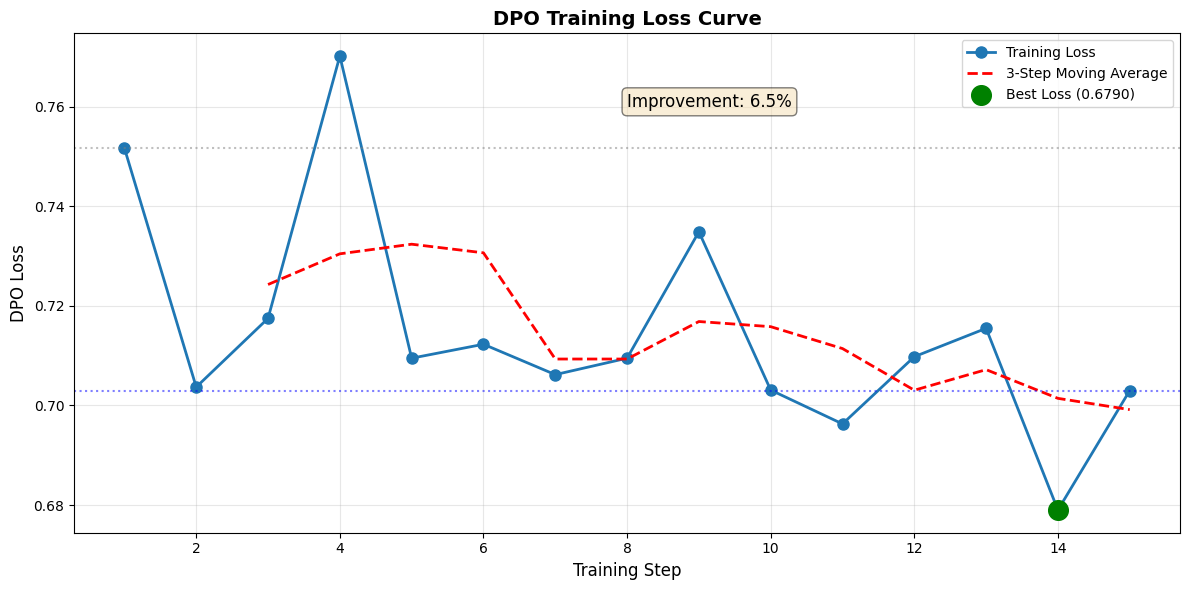

DPO Training Loss Statistics
Initial loss: 0.7517
Final loss: 0.7030
Lowest loss: 0.6790 (Step 14)
Highest loss: 0.7702 (Step 4)
Average loss: 0.7148
Loss standard deviation: 0.0216
Overall improvement: 6.48%


In [12]:
# Training loss data
steps = list(range(1, 16))
losses = [
    0.7517, 0.7037, 0.7175, 0.7702, 0.7095,
    0.7123, 0.7062, 0.7095, 0.7349, 0.7031,
    0.6963, 0.7098, 0.7155, 0.6790, 0.7030
]

# Create the chart
plt.figure(figsize=(12, 6))

# Plot the loss curve
plt.plot(steps, losses, marker='o', linewidth=2, markersize=8, label='Training Loss')

# Add a trendline (moving average)
import numpy as np
window = 3
moving_avg = np.convolve(losses, np.ones(window)/window, mode='valid')
plt.plot(range(window, len(losses)+1), moving_avg,
         linestyle='--', linewidth=2, color='red', label=f'{window}-Step Moving Average')

# Mark the minimum point
min_idx = losses.index(min(losses))
plt.scatter([min_idx + 1], [losses[min_idx]],
            color='green', s=200, zorder=5, label=f'Best Loss ({losses[min_idx]:.4f})')

# Beautify the chart
plt.xlabel('Training Step', fontsize=12)
plt.ylabel('DPO Loss', fontsize=12)
plt.title('DPO Training Loss Curve', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)

# Add annotations
plt.axhline(y=losses[0], color='gray', linestyle=':', alpha=0.5, label='Initial Loss')
plt.axhline(y=losses[-1], color='blue', linestyle=':', alpha=0.5, label='Final Loss')

# Annotate improvement percentage on the plot
improvement = (losses[0] - losses[-1]) / losses[0] * 100
plt.text(8, 0.76, f'Improvement: {improvement:.1f}%',
         fontsize=12, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Print statistics
print("DPO Training Loss Statistics")
print(f"Initial loss: {losses[0]:.4f}")
print(f"Final loss: {losses[-1]:.4f}")
print(f"Lowest loss: {min(losses):.4f} (Step {min_idx + 1})")
print(f"Highest loss: {max(losses):.4f} (Step {losses.index(max(losses)) + 1})")
print(f"Average loss: {np.mean(losses):.4f}")
print(f"Loss standard deviation: {np.std(losses):.4f}")
print(f"Overall improvement: {improvement:.2f}%")

FastVLM DPO vs SFT Evaluation

In [13]:
os.environ["HF_HUB_OFFLINE"] = "1"
os.environ["TRANSFORMERS_OFFLINE"] = "1"
os.environ["HF_DATASETS_OFFLINE"] = "1"

PROJECT = "/content/drive/MyDrive/FastVLM_RLHF"
GT_DIR = f"{PROJECT}/gt_json"
SFT_PRED_DIR = f"{PROJECT}/preds_1.5b"
DPO_PRED_DIR = f"{PROJECT}/preds_dpo"
OUT_DIR = f"{PROJECT}/outputs"
os.makedirs(DPO_PRED_DIR, exist_ok=True)

# Step 1: Validate model and tokenizer
print("Validating model:")

if 'model' not in globals() or model is None:
    raise RuntimeError("Model not found! Please run DPO training first.")

if 'tokenizer' not in globals() or tokenizer is None:
    raise RuntimeError("Tokenizer not found!")

print(f"Model: {type(model).__name__}")
print(f"Tokenizer: {type(tokenizer).__name__}")
print(f"Device: {model.device}")

# Extract base model
print("\nExtracting base model...")
if hasattr(model, 'get_base_model'):
    base_model = model.get_base_model()
    print(f"Using get_base_model(): {type(base_model).__name__}")
elif hasattr(model, 'model') and hasattr(model.model, 'model'):
    base_model = model.model.model
    print(f"Using model.model.model: {type(base_model).__name__}")
elif hasattr(model, 'base_model'):
    if hasattr(model.base_model, 'model'):
        base_model = model.base_model.model
    else:
        base_model = model.base_model
    print(f"Using base_model: {type(base_model).__name__}")
else:
    base_model = model
    print(f"Using model directly: {type(base_model).__name__}")

dpo_model = base_model
dpo_model.eval()

# Step 2: Create a reliable image processing pipeline
print("\nCreating image processor:")

import torchvision.transforms as T

class VisionPreprocessor:
    def __init__(self, image_size=336):
        self.image_size = image_size
        self.transform = T.Compose([
            T.Resize(image_size, interpolation=T.InterpolationMode.BICUBIC),
            T.CenterCrop(image_size),
            T.ToTensor(),
            T.Normalize(
                mean=[0.48145466, 0.4578275, 0.40821073],
                std=[0.26862954, 0.26130258, 0.27577711]
            ),
        ])

    def __call__(self, image):
        """
        Process a single image.
        Input:  PIL Image
        Output: torch.Tensor, shape=(1, 3, H, W), dtype=float32
        """
        if isinstance(image, str):
            image = Image.open(image).convert("RGB")

        # PIL -> Tensor (3, H, W)
        tensor = self.transform(image)

        # Add batch dimension: (3, H, W) -> (1, 3, H, W)
        tensor = tensor.unsqueeze(0)

        return tensor

vision_proc = VisionPreprocessor(image_size=336)
print("Image processor created successfully")

# Smoke test
IMG_DIR = f"{PROJECT}/images"
test_files = [f for f in os.listdir(IMG_DIR) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
if test_files:
    test_img_path = os.path.join(IMG_DIR, test_files[0])
    test_img = Image.open(test_img_path).convert("RGB")
    test_tensor = vision_proc(test_img)
    print(f"Test passed: {test_files[0]}")
    print(f"Input size: {test_img.size}")
    print(f"Output shape: {test_tensor.shape}")
    print(f"Output dtype: {test_tensor.dtype}")
else:
    raise RuntimeError(f"No images found in: {IMG_DIR}")

# Step 3: Define inference functions
print("\nDefining inference functions:")

def generate_with_images(model, tokenizer, image_tensor, prompt, device):
    # Use the `images` argument
    full_prompt = f"<image>\n{prompt}"
    inputs = tokenizer(full_prompt, return_tensors="pt").to(device)
    image_tensor = image_tensor.to(device, dtype=model.dtype)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            images=image_tensor,
            max_new_tokens=256,
            do_sample=False,
            pad_token_id=tokenizer.pad_token_id or tokenizer.eos_token_id,
        )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)

def generate_with_pixel_values(model, tokenizer, image_tensor, prompt, device):
    # Use the `pixel_values` argument
    full_prompt = f"<image>\n{prompt}"
    inputs = tokenizer(full_prompt, return_tensors="pt").to(device)
    image_tensor = image_tensor.to(device, dtype=model.dtype)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            pixel_values=image_tensor,
            max_new_tokens=256,
            do_sample=False,
            pad_token_id=tokenizer.pad_token_id or tokenizer.eos_token_id,
        )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)

def generate_with_manual_forward(model, tokenizer, image_tensor, prompt, device):
    # Manually call forward + decode
    full_prompt = f"<image>\n{prompt}"
    inputs = tokenizer(full_prompt, return_tensors="pt").to(device)
    image_tensor = image_tensor.to(device, dtype=model.dtype)

    # Simple greedy decoding
    with torch.no_grad():
        input_ids = inputs["input_ids"]

        for _ in range(256):
            try:
                outputs = model(
                    input_ids=input_ids,
                    images=image_tensor,
                    use_cache=False,
                )
            except:
                outputs = model(
                    input_ids=input_ids,
                    pixel_values=image_tensor,
                    use_cache=False,
                )

            logits = outputs.logits
            next_token = logits[:, -1, :].argmax(dim=-1, keepdim=True)

            if next_token.item() == tokenizer.eos_token_id:
                break

            input_ids = torch.cat([input_ids, next_token], dim=1)

        return tokenizer.decode(input_ids[0], skip_special_tokens=True)

def predict_with_fallback(image_path, prompt="Describe all parking rules and info in this image."):
    try:
        # Load and process image
        image = Image.open(image_path).convert("RGB")
        image_tensor = vision_proc(image)

        # Method 1: `images` argument
        try:
            full_text = generate_with_images(dpo_model, tokenizer, image_tensor, prompt, dpo_model.device)
            answer = full_text.split(prompt)[-1].strip() if prompt in full_text else full_text.strip()
            return True, answer, "method1_images"
        except Exception as e1:
            error1 = str(e1)

        # Method 2: `pixel_values` argument
        try:
            full_text = generate_with_pixel_values(dpo_model, tokenizer, image_tensor, prompt, dpo_model.device)
            answer = full_text.split(prompt)[-1].strip() if prompt in full_text else full_text.strip()
            return True, answer, "method2_pixel_values"
        except Exception as e2:
            error2 = str(e2)

        # Method 3: manual forward
        try:
            full_text = generate_with_manual_forward(dpo_model, tokenizer, image_tensor, prompt, dpo_model.device)
            answer = full_text.split(prompt)[-1].strip() if prompt in full_text else full_text.strip()
            return True, answer, "method3_manual"
        except Exception as e3:
            error3 = str(e3)

        # All methods failed
        error_msg = f"All methods failed:\n1. {error1[:50]}\n2. {error2[:50]}\n3. {error3[:50]}"
        return False, error_msg, "all_failed"

    except Exception as e:
        return False, f"Image processing failed: {str(e)[:100]}", "preprocessing_failed"

# Inference smoke test
print("\nRunning inference test...")
test_success, test_result, test_method = predict_with_fallback(test_img_path)

if test_success:
    print(f"Test succeeded! Method: {test_method}")
    print(f"Output preview: {test_result[:100]}...")
else:
    print(f"Test failed: {test_method}")
    print(f"Error: {test_result}")
    raise RuntimeError("Inference test failed!")

# Step 4: Batch prediction
image_files = sorted([f for f in os.listdir(IMG_DIR)
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

print(f"Total images: {len(image_files)}")

success_count = 0
method_stats = Counter()
failed_images = []

for img_file in tqdm(image_files, desc="DPO Prediction"):
    base_name = Path(img_file).stem
    pred_path = os.path.join(DPO_PRED_DIR, f"{base_name}.json")

    # Skip if already exists
    if os.path.exists(pred_path):
        success_count += 1
        continue

    # Generate prediction
    img_path = os.path.join(IMG_DIR, img_file)
    success, result, method = predict_with_fallback(img_path)

    if success:
        # Save prediction
        try:
            pred_data = json.loads(result)
        except json.JSONDecodeError:
            pred_data = {"text": result}

        with open(pred_path, 'w', encoding='utf-8') as f:
            json.dump(pred_data, f, ensure_ascii=False, indent=2)

        success_count += 1
        method_stats[method] += 1
    else:
        failed_images.append((img_file, result))

print(f"\nPrediction finished: {success_count}/{len(image_files)}")
print(f"Method stats: {dict(method_stats)}")

if failed_images:
    print(f"\nFailed images ({len(failed_images)}):")
    for img, err in failed_images[:5]:
        print(f"  - {img}: {err[:80]}")

if success_count == 0:
    print("All predictions failed!")
    print("\nFinal diagnostics:")
    print(f"Model type: {type(dpo_model).__name__}")
    print(f"Model device: {dpo_model.device}")
    print(f"Test result: {test_result[:200]}")

    # Try to inspect model signature
    import inspect
    if hasattr(dpo_model, 'generate'):
        try:
            sig = str(inspect.signature(dpo_model.generate))
            print(f"generate signature: {sig[:200]}")
        except:
            print("Unable to get generate signature")

    raise RuntimeError("Prediction failed! Please check the model and image processing logic.")

# Step 5: Evaluation
KEYS = [
    "NO STOPPING", "NO PARKING", "DISABLE", "DISABLED", "DISABLE PEOPLE ONLY",
    "1P", "2P", "3P", "TICKET", "PERMIT", "BUS", "PARALLEL", "ANGLED",
    "AM", "PM", "MON", "TUE", "WED", "THU", "FRI", "SAT", "SUN",
    "LEFT", "RIGHT", "BOTH", "↔", "→", "←", "AREA", "ZONE"
]

def norm_text(s):
    s = unicodedata.normalize("NFKC", s)
    s = re.sub(r"[\s,;:|/]+", " ", s).upper()
    s = s.replace("DISABLED", "DISABLE")
    s = s.replace("↔", "BOTH").replace("→", "RIGHT").replace("←", "LEFT")
    return s.replace("  ", " ").strip()

def load_json_any(path):
    try:
        with open(path, "r", encoding="utf-8") as f:
            return json.load(f)
    except:
        return None

def flatten_gt(path):
    obj = load_json_any(path)
    if not obj:
        return ""
    pieces = []
    if isinstance(obj, list):
        for item in obj:
            if isinstance(item, dict):
                for k, v in item.items():
                    if isinstance(v, str) and "=" in v:
                        kk, vv = v.split("=", 1)
                        pieces += [kk, vv]
                    else:
                        pieces += [str(k), str(v)]
            else:
                pieces.append(str(item))
    elif isinstance(obj, dict):
        for k, v in obj.items():
            pieces += [str(k), str(v)]
    else:
        pieces.append(str(obj))
    return norm_text(" ".join(pieces))

def flatten_pred(path):
    obj = load_json_any(path)
    if not obj:
        try:
            return norm_text(open(path, "r", encoding="utf-8").read())
        except:
            return ""
    if isinstance(obj, dict) and "text" in obj:
        return norm_text(obj["text"])
    return norm_text(json.dumps(obj, ensure_ascii=False))

def extract_keys(norm_str):
    return set(k for k in KEYS if k in norm_str)

def evaluate_predictions(pred_dir, model_name):
    print(f"\nEvaluating model {model_name}...")

    rows = []
    per_key_tp = Counter()
    per_key_fp = Counter()
    per_key_fn = Counter()

    gt_files = sorted(glob.glob(f"{GT_DIR}/*.json"))
    matched = 0

    for gt_path in gt_files:
        base = Path(gt_path).stem

        # Find matching prediction
        pred_path = None
        for cand in [f"{base}.json", f"{base}.JPG.json", f"{base}.jpg.json"]:
            p = os.path.join(pred_dir, cand)
            if os.path.exists(p):
                pred_path = p
                break

        if not pred_path:
            continue

        matched += 1

        # Extract keywords
        gset = extract_keys(flatten_gt(gt_path))
        pset = extract_keys(flatten_pred(pred_path))

        # Metrics
        tp = len(gset & pset)
        fp = len(pset - gset)
        fn = len(gset - pset)

        prec = tp / (tp + fp) if (tp + fp) else 0.0
        rec = tp / (tp + fn) if (tp + fn) else 0.0
        f1 = 2 * prec * rec / (prec + rec) if (prec + rec) else 0.0

        rows.append([base, tp, fp, fn, prec, rec, f1, gset, pset])

        # Per-key counters
        for k in (gset & pset):
            per_key_tp[k] += 1
        for k in (pset - gset):
            per_key_fp[k] += 1
        for k in (gset - pset):
            per_key_fn[k] += 1

    print(f"Matched samples: {matched}/{len(gt_files)}")

    if matched == 0:
        print("No matched samples!")
        return None

    # Micro metrics
    micro_tp = sum(r[1] for r in rows)
    micro_fp = sum(r[2] for r in rows)
    micro_fn = sum(r[3] for r in rows)
    micro_prec = micro_tp / (micro_tp + micro_fp) if (micro_tp + micro_fp) else 0.0
    micro_rec = micro_tp / (micro_tp + micro_fn) if (micro_tp + micro_fn) else 0.0
    micro_f1 = 2 * micro_prec * micro_rec / (micro_prec + micro_rec) if (micro_prec + micro_rec) else 0.0

    # Macro metrics
    avg_prec = sum(r[4] for r in rows) / len(rows)
    avg_rec = sum(r[5] for r in rows) / len(rows)
    avg_f1 = sum(r[6] for r in rows) / len(rows)

    # Per-key stats
    key_stats = []
    for k in sorted(set(list(per_key_tp) + list(per_key_fp) + list(per_key_fn))):
        tp, fp, fn = per_key_tp[k], per_key_fp[k], per_key_fn[k]
        p = tp / (tp + fp) if (tp + fp) else 0.0
        r = tp / (tp + fn) if (tp + fn) else 0.0
        f1_k = 2 * p * r / (p + r) if (p + r) else 0.0
        key_stats.append([k, tp, fp, fn, p, r, f1_k])

    return {
        "model_name": model_name,
        "rows": rows,
        "micro": {"precision": micro_prec, "recall": micro_rec, "f1": micro_f1},
        "macro": {"precision": avg_prec, "recall": avg_rec, "f1": avg_f1},
        "per_key": key_stats,
        "per_key_counters": (per_key_tp, per_key_fp, per_key_fn)
    }

# Evaluate both models
sft_results = evaluate_predictions(SFT_PRED_DIR, "SFT")
dpo_results = evaluate_predictions(DPO_PRED_DIR, "DPO")

if not sft_results or not dpo_results:
    raise RuntimeError("Evaluation failed!")

# Step 6: Print results
def print_results(results):
    name = results["model_name"]
    micro = results["micro"]
    macro = results["macro"]

    print(f"[{name} Model]")
    print(f"Samples: {len(results['rows'])}")
    print(f"\nMicro metrics:")
    print(f"Precision: {micro['precision']:.3f}")
    print(f"Recall:    {micro['recall']:.3f}")
    print(f"F1 Score:  {micro['f1']:.3f}")
    print(f"\nMacro metrics:")
    print(f"Precision: {macro['precision']:.3f}")
    print(f"Recall:    {macro['recall']:.3f}")
    print(f"F1 Score:  {macro['f1']:.3f}")

    print(f"\nPer-key stats (sorted by frequency)")
    for line in sorted(results['per_key'], key=lambda x: x[1]+x[2]+x[3], reverse=True)[:15]:
        print(f"{line[0]:>20s} | TP:{line[1]:2d} FP:{line[2]:2d} FN:{line[3]:2d} | "
              f"P/R/F1={line[4]:.3f}/{line[5]:.3f}/{line[6]:.3f}")

print_results(sft_results)
print_results(dpo_results)

# Comparative analysis
print("SFT vs DPO Comparative Analysis")

sft_micro = sft_results["micro"]
dpo_micro = dpo_results["micro"]
sft_macro = sft_results["macro"]
dpo_macro = dpo_results["macro"]

print(f"\n{'Metric':<20s} {'SFT':<12s} {'DPO':<12s} {'Change':<20s}")
print("-" * 70)

metrics = [
    ("Micro Precision", sft_micro["precision"], dpo_micro["precision"]),
    ("Micro Recall", sft_micro["recall"], dpo_micro["recall"]),
    ("Micro F1", sft_micro["f1"], dpo_micro["f1"]),
    ("Macro Precision", sft_macro["precision"], dpo_macro["precision"]),
    ("Macro Recall", sft_macro["recall"], dpo_macro["recall"]),
    ("Macro F1", sft_macro["f1"], dpo_macro["f1"]),
]

for name, sft_val, dpo_val in metrics:
    delta = dpo_val - sft_val
    delta_pct = (delta / sft_val * 100) if sft_val > 0 else 0
    arrow = "↑" if delta > 0 else "↓" if delta < 0 else "="
    print(f"{name:<20s} {sft_val:>6.3f}       {dpo_val:>6.3f}       "
          f"{arrow} {delta:+.3f} ({delta_pct:+.1f}%)")

# Key improvements
print("\nKey improvement analysis:")

# Hallucination control
hallucination_keys = ["AREA", "BUS", "ZONE", "PERMIT", "TICKET"]
sft_tp, sft_fp, sft_fn = sft_results["per_key_counters"]
dpo_tp, dpo_fp, dpo_fn = dpo_results["per_key_counters"]

print("\nHallucination control (False Positives):")
for key in hallucination_keys:
    sft_fp_val = sft_fp[key]
    dpo_fp_val = dpo_fp[key]
    if sft_fp_val > 0 or dpo_fp_val > 0:
        reduction = sft_fp_val - dpo_fp_val
        status = "Yes" if reduction > 0 else "No" if reduction < 0 else "="
        print(f"  {status} {key:>10s}: {sft_fp_val:2d} → {dpo_fp_val:2d} ({reduction:+2d})")

# Missing reduction
missing_keys = ["RIGHT", "SUN", "SAT", "3P", "PARALLEL"]
print("\nMissing reduction (False Negatives):")
for key in missing_keys:
    sft_fn_val = sft_fn[key]
    dpo_fn_val = dpo_fn[key]
    if sft_fn_val > 0 or dpo_fn_val > 0:
        reduction = sft_fn_val - dpo_fn_val
        status = "Yes" if reduction > 0 else "No" if reduction < 0 else "="
        print(f"  {status} {key:>10s}: {sft_fn_val:2d} → {dpo_fn_val:2d} ({reduction:+2d})")

# Overall tallies
total_sft_fp = sum(sft_fp.values())
total_dpo_fp = sum(dpo_fp.values())
total_sft_fn = sum(sft_fn.values())
total_dpo_fn = sum(dpo_fn.values())

print(f"\nOverall error counts:")
fp_change = total_dpo_fp - total_sft_fp
fn_change = total_dpo_fn - total_sft_fn
print(f"  False Positives: {total_sft_fp} → {total_dpo_fp} "
      f"({fp_change:+d}, {fp_change/total_sft_fp*100:+.1f}%)")
print(f"  False Negatives: {total_sft_fn} → {total_dpo_fn} "
      f"({fn_change:+d}, {fn_change/total_sft_fn*100:+.1f}%)")

# Step 7: Export results
for prefix, results in [("sft", sft_results), ("dpo", dpo_results)]:
    # By image
    csv_image = f"{OUT_DIR}/eval_{prefix}_by_image.csv"
    with open(csv_image, "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(["id", "TP", "FP", "FN", "Precision", "Recall", "F1", "GT_Keys", "Pred_Keys"])
        for row in results["rows"]:
            w.writerow([
                row[0], row[1], row[2], row[3],
                f"{row[4]:.4f}", f"{row[5]:.4f}", f"{row[6]:.4f}",
                ";".join(sorted(row[7])), ";".join(sorted(row[8]))
            ])

    # By key
    csv_key = f"{OUT_DIR}/eval_{prefix}_by_key.csv"
    with open(csv_key, "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(["Key", "TP", "FP", "FN", "Precision", "Recall", "F1"])
        for row in results["per_key"]:
            w.writerow([
                row[0], row[1], row[2], row[3],
                f"{row[4]:.3f}", f"{row[5]:.3f}", f"{row[6]:.3f}"
            ])

# Comparison table
csv_compare = f"{OUT_DIR}/eval_sft_vs_dpo_comparison.csv"
with open(csv_compare, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["Metric", "SFT", "DPO", "Delta", "Delta_%"])
    for name, sft_val, dpo_val in metrics:
        delta = dpo_val - sft_val
        delta_pct = (delta / sft_val * 100) if sft_val > 0 else 0
        w.writerow([name, f"{sft_val:.4f}", f"{dpo_val:.4f}",
                   f"{delta:+.4f}", f"{delta_pct:+.2f}%"])

print(f"\nDetailed outputs:")
print(f"SFT by-image: {OUT_DIR}/eval_sft_by_image.csv")
print(f"SFT by-key:   {OUT_DIR}/eval_sft_by_key.csv")
print(f"DPO by-image: {OUT_DIR}/eval_dpo_by_image.csv")
print(f"DPO by-key:   {OUT_DIR}/eval_dpo_by_key.csv")
print(f"Comparison:   {OUT_DIR}/eval_sft_vs_dpo_comparison.csv")

# Step 8: Summary
improvement = dpo_micro["f1"] - sft_micro["f1"]
improvement_pct = (improvement / sft_micro["f1"] * 100) if sft_micro["f1"] > 0 else 0

if improvement > 0.05:
    verdict = "DPO training significantly improved model performance!"
elif improvement > 0:
    verdict = "DPO training brought a moderate improvement."
elif improvement > -0.05:
    verdict = "DPO training had limited effect."
else:
    verdict = "DPO training did not improve performance."

print(f"""
{verdict}

Key metric comparison:
  - SFT F1: {sft_micro['f1']:.3f}
  - DPO F1: {dpo_micro['f1']:.3f}
  - Delta:  {improvement:+.3f} ({improvement_pct:+.1f}%)

Main changes:
  - Precision: {sft_micro['precision']:.3f} → {dpo_micro['precision']:.3f}
  - Recall:    {sft_micro['recall']:.3f} → {dpo_micro['recall']:.3f}
  - Hallucination reduction (FP): {fp_change:+d} ({fp_change/total_sft_fp*100:+.1f}%)

All results exported to: {OUT_DIR}
""")

Validating model:
Model: PeftModelForCausalLM
Tokenizer: Qwen2Tokenizer
Device: cuda:0

Extracting base model...
Using get_base_model(): LlavaQwen2ForCausalLM

Creating image processor:
Image processor created successfully
Test passed: IMG_6460.JPG
Input size: (2160, 2880)
Output shape: torch.Size([1, 3, 336, 336])
Output dtype: torch.float32

Defining inference functions:

Running inference test...
Test succeeded! Method: method3_manual
Output preview: No parking...
Total images: 20


DPO Prediction: 100%|██████████| 20/20 [00:00<00:00, 103.15it/s]


Prediction finished: 20/20
Method stats: {}

Evaluating model SFT...


Matched samples: 20/20

Evaluating model DPO...
Matched samples: 20/20
[SFT Model]
Samples: 20

Micro metrics:
Precision: 0.305
Recall:    0.736
F1 Score:  0.431

Macro metrics:
Precision: 0.306
Recall:    0.752
F1 Score:  0.407

Per-key stats (sorted by frequency)
                  2P | TP:10 FP:10 FN: 0 | P/R/F1=0.500/1.000/0.667
                  AM | TP:11 FP: 9 FN: 0 | P/R/F1=0.550/1.000/0.710
                AREA | TP: 0 FP:20 FN: 0 | P/R/F1=0.000/0.000/0.000
                 BUS | TP: 0 FP:20 FN: 0 | P/R/F1=0.000/0.000/0.000
             DISABLE | TP: 4 FP:16 FN: 0 | P/R/F1=0.200/1.000/0.333
 DISABLE PEOPLE ONLY | TP: 4 FP:16 FN: 0 | P/R/F1=0.200/1.000/0.333
                LEFT | TP:13 FP: 6 FN: 1 | P/R/F1=0.684/0.929/0.788
                 MON | TP: 5 FP:15 FN: 0 | P/R/F1=0.250/1.000/0.400
              PERMIT | TP: 2 FP:18 FN: 0 | P/R/F1=0.100/1.000/0.182
                  PM | TP:11 FP: 9 FN: 0 | P/R/F1=0.550/1.000/0.710
              TICKET | TP: 9 FP:11 FN: 0 | P/R/F1=0.45

Generate prediction timing

In [20]:
# Output directory
OUT_DIR = "/content/drive/MyDrive/FastVLM_RLHF/preds_timed"
os.makedirs(OUT_DIR, exist_ok=True)

total_time = 0.0
n = len(files)
print(f"Total number of images: {n}")

for i, img_path in enumerate(files, 1):
    base = Path(img_path).stem
    print(f"\n[{i}/{n}] Starting prediction: {base}")

    # Timing for a single image
    t0 = time.time()
    pred_text = generate_prediction(img_path)
    torch.cuda.synchronize() if torch.cuda.is_available() else None
    t1 = time.time()

    dt = t1 - t0
    total_time += dt
    print(f"Done: {base}  |  Time taken: {dt:.2f} seconds")

    # Save the result (to prevent data loss)
    try:
        obj = json.loads(pred_text) if isinstance(pred_text, str) else pred_text
        if not isinstance(obj, (dict, list)):
            obj = {"text": pred_text}
    except Exception:
        obj = {"text": pred_text}

    out_path = os.path.join(OUT_DIR, f"{base}.json")
    with open(out_path, "w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

print(f"\nTotal inference time: {total_time:.2f} seconds")
print(f"Average per image: {total_time / max(n,1):.2f} seconds")

Total number of images: 20

[1/20] Starting prediction: IMG_6460
Failed to process /content/drive/MyDrive/FastVLM_RLHF/images/IMG_6460.JPG: 'NoneType' object is not callable
Done: IMG_6460  |  Time taken: 0.05 seconds

[2/20] Starting prediction: IMG_6462
Failed to process /content/drive/MyDrive/FastVLM_RLHF/images/IMG_6462.JPG: 'NoneType' object is not callable
Done: IMG_6462  |  Time taken: 0.04 seconds

[3/20] Starting prediction: IMG_6464
Failed to process /content/drive/MyDrive/FastVLM_RLHF/images/IMG_6464.JPG: 'NoneType' object is not callable
Done: IMG_6464  |  Time taken: 0.05 seconds

[4/20] Starting prediction: IMG_6468
Failed to process /content/drive/MyDrive/FastVLM_RLHF/images/IMG_6468.JPG: 'NoneType' object is not callable
Done: IMG_6468  |  Time taken: 0.05 seconds

[5/20] Starting prediction: IMG_6470
Failed to process /content/drive/MyDrive/FastVLM_RLHF/images/IMG_6470.JPG: 'NoneType' object is not callable
Done: IMG_6470  |  Time taken: 0.05 seconds

[6/20] Starting p